In [19]:
import helper
import numpy as np
import pandas as pd
import os, time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from datasets import Dataset, load_dataset, load_metric
from transformers import (
    MarianTokenizer,
    MBart50TokenizerFast,
    AutoModelForSeq2SeqLM, 
    DataCollatorForSeq2Seq, 
    Seq2SeqTrainingArguments, 
    Seq2SeqTrainer,
    utils
)
from datasets import concatenate_datasets



### Global Variables

In [2]:
# Set the Global Parametre
utils.logging.set_verbosity(50)
os.environ["TOKENIZERS_PARALLELISM"] = "true"
config = helper.read_config()
SEED = 99
TOKEN = config['Data_Tokens']['token']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
asian_tokens = r"data/tokens.txt"

### Tokenizer


In [4]:
def load_tokenizer(tk_model):
    utils.logging.set_verbosity(50)
    mr_tknzr = MarianTokenizer.from_pretrained(tk_model)
    with open(asian_tokens) as fp:
        tokens = fp.read().split("\n")
    mr_tknzr.add_tokens(tokens, special_tokens=True)
    return mr_tknzr

In [5]:
# Loading pre-trained tokenizer.
utils.logging.set_verbosity(50)
xxlang = 'zh'
pretrained_models = {
        "zh":"Helsinki-NLP/opus-mt-en-zh",
        "ja":"Helsinki-NLP/opus-tatoeba-en-ja"
    }

print(pretrained_models[xxlang])
model_pretrained = pretrained_models[xxlang]
pretrained_tknzr = load_tokenizer(pretrained_models[xxlang])

Helsinki-NLP/opus-mt-en-zh


In [6]:
# Pre Processing
ip_lenght = 128
op_lenght = 128

### Data Pre-Processing Methods

In [7]:
def data_preprocess(examples):
    utils.logging.set_verbosity(50)
    ip_sent = [s for s in examples["Sent_en"]]
    target_sent = [s for s in examples["Sent_yy"]]
    
    model_ip = pretrained_tknzr(ip_sent, max_length=128, truncation=True, padding="max_length")
    
    labels = pretrained_tknzr(target_sent, max_length=128, truncation=True, padding="max_length")

    if len(examples['Sent_en']) > 1 and (len(model_ip['input_ids'][0]) != len(model_ip["input_ids"][1])):
        print ("Error!", )

    model_ip["labels"] = labels["input_ids"]
    
    return model_ip

In [8]:
metric = load_metric("sacrebleu")
    
def compute_bleu(eval_preds, tokenizer=pretrained_tknzr , metric= metric):
    utils.logging.set_verbosity(50)
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
        
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels] 
        
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": round(result["score"], 4)}
    
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = round(np.mean(prediction_lens), 4)

    return result

### Load Data

In [9]:
data_files = {"train": "train.parquet", "test": "test.parquet", "eval": "eval.parquet"}
dataset = load_dataset("/workspace/project/data", data_files= data_files)

Using custom data configuration data-1fc2412c1e98613e
Reusing dataset parquet (/root/.cache/huggingface/datasets/parquet/data-1fc2412c1e98613e/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121)


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
batch_size = 64
transformation_cols = ['input_ids', 'labels', 'attention_mask']
yylang = 'ms'

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['SID', 'Sent_en', 'Sent_yy', 'lang_yy'],
        num_rows: 179199
    })
    test: Dataset({
        features: ['SID', 'Sent_en', 'Sent_yy', 'lang_yy'],
        num_rows: 10101
    })
    eval: Dataset({
        features: ['SID', 'Sent_en', 'Sent_yy', 'lang_yy'],
        num_rows: 9930
    })
})

In [ ]:
def filter_fn(example):
    return example['lang_yy'] == yylang

# data_subset = dataset.filter(lambda example: example['lang_yy'] == yylang)

data_subset = dataset.filter(filter_fn)

print(10)
# data_subset = data_subset.map(data_preproces, batched=True, batch_size=batch_size*3, fn_kwargs={'pretrained_tknzr': pretrained_tknzr})
data_subset1 = data_subset.map(data_preprocess, batched=True, batch_size=batch_size*3)
print(11)
data_subset1.set_format(type='torch', columns=transformation_cols)


### Fine Tuning the Pre-Trained Model on one target Language

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_pretrained).to(device)
model.resize_token_embeddings(len(pretrained_tknzr))

collator = DataCollatorForSeq2Seq(pretrained_tknzr, model=model)

args = Seq2SeqTrainingArguments(
    output_dir = f"NMT_PFT_en-{xxlang}-to-{yylang}",
    seed = 99,
    evaluation_strategy = "epoch",
    log_level = 'warning',
    disable_tqdm = False,
    learning_rate=1e-4,
    per_device_train_batch_size= 16,
    per_device_eval_batch_size= 16,
    weight_decay=0.01,
    warmup_steps = 10,
    num_train_epochs=15,
    predict_with_generate=True,
    remove_unused_columns = True,
    fp16=True,
    save_total_limit=3,
    save_strategy = "epoch",
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=data_subset["train"],
    eval_dataset=data_subset["eval"],
    tokenizer=pretrained_tknzr,
    compute_metrics=compute_bleu,
    data_collator=collator,
)

### Train Model

In [ ]:
trainer.train()

### Model Evaluation

In [ ]:
trainer.predict(data_subset["test"])

# ----- Pure - Fine tunning -----

### Data Prep

In [12]:
yy_subset = ['fil', 'hi', 'id', 'ja', 'khm', 'ms', 'my', 'th', 'vi']
xx_size = 18_000

def rename_key(example):
    example["Sent_en"] = example["translation"]["en"]
    example["Sent_yy"] = example["translation"][xxlang]
    return example
    
def concat_data(data, xxlang, xx_size = 20_000, mix_subset = ["vi"] ):
    
    select_lang = lambda x: x["lang_yy"] in mix_subset
    
    data_subset = data["train"].filter(select_lang).remove_columns(["SID", "lang_yy"])
    
    xx_data = load_dataset("opus100", f'en-{xxlang}', split = "train")

    xx_train = xx_data.select(range(xx_size)).map(rename_key).remove_columns("translation")

    data_concat = concatenate_datasets([data_subset, xx_train])
    
    pad = "*"*4
    print(f"{pad}Alt dataset used for mix training{pad}\nTotal Languages: {len(mix_subset)}\nSentences: {len(data_subset)}")
    print(f"{pad}Opus dataset used for mix training{pad}\nLanguages: en-zh\nSentences: {xx_train}")
    print(f"{pad}Final dataset for Mix Training{pad}\nLanguages: {1+len(mix_subset)}\nSentences: {len(data_concat)}")
    
    return data_concat.shuffle(seed = SEED)

data_mix = concat_data(data= dataset, xxlang = xxlang, xx_size = xx_size, mix_subset = ['fil', 'hi', 'id', 'ja', 'khm', 'ms', 'my', 'th', 'vi'])

Parameter 'function'=<function concat_data.<locals>.<lambda> at 0x7f801ed63310> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/180 [00:00<?, ?ba/s]

Reusing dataset opus100 (/root/.cache/huggingface/datasets/opus100/en-zh/0.0.0/256f3196b69901fb0c79810ef468e2c4ed84fbd563719920b1ff1fdc750f7704)


  0%|          | 0/18000 [00:00<?, ?ex/s]

****Alt dataset used for mix training****
Total Languages: 9
Sentences: 161111
****Opus dataset used for mix training****
Languages: en-zh
Sentences: Dataset({
    features: ['Sent_en', 'Sent_yy'],
    num_rows: 18000
})
****Final dataset for Mix Training****
Languages: 10
Sentences: 179111


In [ ]:
data_mix

### Pre- Process Data

In [13]:
# data_mix_train = data_mix.map(data_preproces, batched=True, batch_size=batch_size*3, fn_kwargs={'pretrained_tknzr': pretrained_tknzr})
data_mix_train = data_mix.map(data_preprocess, batched=True, batch_size=batch_size*3)
data_mix_train.set_format(type='torch', columns=transformation_cols)

eval_data_mix = dataset["eval"].filter(lambda x: x["lang_yy"] in yy_subset)
# eval_data_mix = eval_data_mix.map(data_preproces, batched=True, batch_size=batch_size, fn_kwargs={'pretrained_tknzr': pretrained_tknzr})
eval_data_mix = eval_data_mix.map(data_preprocess, batched=True, batch_size=batch_size)
eval_data_mix.set_format(type='torch', columns=transformation_cols)

  0%|          | 0/933 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/140 [00:00<?, ?ba/s]

### Load Model and Train on Mix Data 

In [14]:
utils.logging.set_verbosity(25)
model = AutoModelForSeq2SeqLM.from_pretrained(model_pretrained).to(device)
model.resize_token_embeddings(len(pretrained_tknzr))

collator = DataCollatorForSeq2Seq(pretrained_tknzr, model=model)

args = Seq2SeqTrainingArguments(
    output_dir = f"NMT_Mix_en-{xxlang}-to-{yylang}",
    seed = 99,
    evaluation_strategy = "steps",
    eval_steps = 10_000,
    log_level = 'warning',
    disable_tqdm = False,
    
    save_total_limit=3,
    save_strategy = 'steps', #"epoch",
    save_steps = 10_000,
    push_to_hub = False,
    hub_token = TOKEN,
    hub_model_id = f"NMT_Mix_en-{xxlang}-to-{yylang}",
    hub_strategy = "checkpoint",
    
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    warmup_steps = 10,
    num_train_epochs=5,
    predict_with_generate=True,
    remove_unused_columns = True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=data_mix_train,
    eval_dataset=eval_data_mix,
    data_collator=collator,
    tokenizer=pretrained_tknzr,
    compute_metrics=compute_bleu,
)

In [15]:
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/trainer.py:1364: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(


Step,Training Loss,Validation Loss,Bleu,Gen Len
10000,1.250600,1.321967,9.938800,58.168300
20000,0.960500,1.021635,17.274000,45.566300
30000,0.811000,0.898940,21.253100,45.449900
40000,0.743900,0.822815,23.405600,43.559000
50000,0.655400,0.775739,25.612600,44.347600
60000,0.620200,0.739401,26.969800,44.643800
70000,0.547200,0.715244,27.851600,43.798400
80000,0.530600,0.693762,28.675900,44.132500
90000,0.479800,0.679192,29.552000,43.759900
100000,0.478000,0.667674,30.088100,44.366500


/opt/conda/lib/python3.8/site-packages/transformers/trainer.py:1364: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
/opt/conda/lib/python3.8/site-packages/transformers/trainer.py:1364: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
/opt/conda/lib/python3.8/site-packages/transformers/trainer.py:1364: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default 

TrainOutput(global_step=111945, training_loss=0.7493315314590608, metrics={'train_runtime': 23243.1397, 'train_samples_per_second': 38.53, 'train_steps_per_second': 4.816, 'total_flos': 6.071570040619008e+16, 'train_loss': 0.7493315314590608, 'epoch': 5.0})

### Loding the model trained above

In [27]:
model = AutoModelForSeq2SeqLM.from_pretrained(f"NMT_Mix_en-{xxlang}-to-{yylang}")
model.resize_token_embeddings(len(pretrained_tknzr))

Embedding(101462, 512, padding_idx=65000)

In [29]:
target_lang = 'ms'# == yylang

data_subset = dataset.filter(lambda x: x["lang_yy"] == target_lang)
data_subset = data_subset.map(data_preprocess, batched=True, batch_size=batch_size*3)
data_subset.set_format(type='torch', columns=transformation_cols)

  0%|          | 0/180 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/94 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

### Load Model and Train on Target Language

In [32]:
collator = DataCollatorForSeq2Seq(pretrained_tknzr, model=model)

args = Seq2SeqTrainingArguments(
    output_dir = f"NMT_Final_{target_lang}",
    seed = 99,
    evaluation_strategy = "epoch",
    log_level = 'warning',
    disable_tqdm = False,
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    warmup_steps = 5,
    num_train_epochs=5,
    predict_with_generate=True,
    remove_unused_columns = True,
    fp16=True,
    save_total_limit=3,
    save_strategy = "epoch",
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=data_subset["train"],
    eval_dataset=data_subset["eval"],
    data_collator=collator,
    tokenizer= pretrained_tknzr,
    compute_metrics= compute_bleu
)

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,0.329200,0.426728,43.845800,37.344700
2,0.248400,0.419369,44.882200,37.301500
3,0.181200,0.414721,45.725700,37.269300
4,0.136500,0.419384,46.302000,37.511600
5,0.104600,0.421675,46.766200,37.532700


/opt/conda/lib/python3.8/site-packages/transformers/trainer.py:1364: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
/opt/conda/lib/python3.8/site-packages/transformers/trainer.py:1364: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(


TrainOutput(global_step=11220, training_loss=0.19844589114401642, metrics={'train_runtime': 1796.476, 'train_samples_per_second': 49.956, 'train_steps_per_second': 6.246, 'total_flos': 6084417520926720.0, 'train_loss': 0.19844589114401642, 'epoch': 5.0})

In [34]:
trainer.predict(data_subset["test"])

PredictionOutput(predictions=array([[65000, 74604, 79074, ..., 65000, 65000, 65000],
       [65000, 66619,     8, ..., 65000, 65000, 65000],
       [65000, 74604, 80960, ..., 65000, 65000, 65000],
       ...,
       [65000, 70610,    13, ..., 65000, 65000, 65000],
       [65000, 79469, 79178, ..., 65000, 65000, 65000],
       [65000, 79480,    13, ..., 65000, 65000, 65000]]), label_ids=array([[80584, 70261, 79475, ..., 65000, 65000, 65000],
       [66619,     8, 10139, ..., 65000, 65000, 65000],
       [ 9280, 80347,     8, ..., 65000, 65000, 65000],
       ...,
       [79402,     8,  3005, ..., 65000, 65000, 65000],
       [79469, 79157, 73645, ..., 65000, 65000, 65000],
       [79480, 70161, 79433, ..., 65000, 65000, 65000]]), metrics={'eval_loss': 0.4476158618927002, 'eval_bleu': 45.1078, 'eval_gen_len': 38.0305, 'eval_runtime': 78.84, 'eval_samples_per_second': 12.9, 'eval_steps_per_second': 1.624})

### Analysis

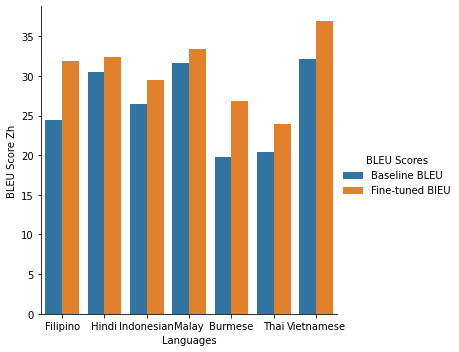

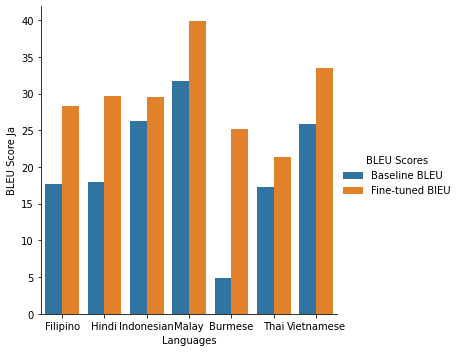

In [21]:
bleu_df = pd.DataFrame(data={'BLEU Scores': ['Baseline BLEU','Fine-tuned BlEU']*7, \
    'Languages': ['Filipino', 'Filipino', 'Hindi', 'Hindi', 'Indonesian', \
        'Indonesian', 'Malay', 'Malay', 'Burmese', 'Burmese', 'Thai', 'Thai',\
            'Vietnamese', 'Vietnamese'], \
                'BLEU Score Zh': [24.45, 31.81, 30.49, 32.43, 26.41, 29.47,\
                    31.65, 33.35, 19.82, 26.81, 20.42, 23.91, 32.14, 36.91],\
                        'BLEU Score Ja': [17.62, 28.37, 17.96, 29.63, 26.33, 29.54,\
                            31.74, 39.88, 4.84, 25.11, 17.21, 21.42, 25.87, 33.45]\
                                })


sns.catplot(x = 'Languages', y='BLEU Score Zh', hue = 'BLEU Scores',data=bleu_df, kind='bar')
sns.catplot(x = 'Languages', y='BLEU Score Ja', hue = 'BLEU Scores',data=bleu_df, kind='bar')

plt.show()

As helper languages, Chinese and Japanese, the BLEU ratings for each configuration are displayed above. For the mix fine tune with pure tuning setups, regardless of the external parallel corpus for en-xx, the three-stage fine-tuned model, Pure-fine tuning with Chinese as a helper language achieved the highest BLEU scores for all seven target languages. Results for Baseline techniques using Japanese as the helper language demonstrate that NMT systems trained on 18k parallel phrases can only get a subpar outcome for the target language "My" while the other target languages achieve reasonably high BLEU scores (20).  No matter how it was applied, the combination of mixed pre-training and pure fine-tuning, as well as the addition of a sizeable external en-xx parallel corpus, consistently and dramatically improved the translation quality for each of the seven target languages. For all of the examples, pure fine-tuning using Chinese and Japanese as auxiliary languages produced the greatest results. The BLEU increased from 1.94 (Hi) to 6.99 (Ms) points when using the En-Zh corpus, and from 3.17 (Id) to 20.27 (My) points when using the En-Ja corpus.


With improvements over the best scores of 1.94 (Hi) to 6.99 (Ms) BLEU points with the En-Zh corpus, the three-stage fine-tuned model using Chinese as a helper language consistently beat the En-Ja pure fine-tuned model. These models don't add any extra source sentences compared to baseline, as was previously mentioned. Therefore, we can claim with certainty that the benefit is the result of multilingualism. When all En-yy language pairings were utilised for the three-stage fine-tuning model, the En-Ja corpus likewise showed a significant superiority gain (for Hi, Ms, My, and Vi) over the En-Zh corpus. When all of the target languages were used, however, the En-Zh corpus frequently helped to achieve considerably better results than the En-Ja corpus (for Fi and Id). The size of the corpus, the similarity or overlap between the interest and helping target languages, and the proximity of the domain are three potential contributing variables.

En-Ja corpus performed 2.48 BLEU points better than En-Zh corpus when used as helping data for En-Ja translation.
The significant BLEU gap could be explained by the fact that the En-Ja corpus is more than twice as big as the En-Zh corpus. Even if it is conceivable that the Chinese and Japanese languages' vocabulary overlaps to aid in En-Ja translation, other languages also do better even when there isn't. We believe that translation into a low-resource target language may benefit from being the target side of the supporting corpus, but multistage fine-tuning does not require this overlap and instead performs best when it makes use of multilingualism during stage-wise tuning.